[Data Visualization on Tableau](https://public.tableau.com/views/AirBnBinMilan_17060112236490/Story1?:language=en-US&publish=yes&:display_count=n&:origin=viz_share_link)

## Import Basic Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn as sns; sns.set()

In [2]:
df = pd.read_csv(r'C:\Users\matte\OneDrive\Desktop\GitHub\data\Airbnb\listings_cleaned.csv')
df.head()

,id,name,price,room_type,number_of_reviews,stars,bed,bedroom,bath,neighbourhood,latitude,longitude,minimum_nights,last_review,reviews_per_month,number_of_reviews_ltm,calculated_host_listings_count,host_id,days_online
0,23986,Rental unit in Milan · ★4.64 · 1 bedroom · 1 b...,150.0,Entire home/apt,26.0,4.64,1.0,1.0,1.0,NAVIGLI,45.44806,9.17373,1.0,2023-07-29,0.18,4.0,1.0,95941,4261.0
1,40470,Rental unit in Milan · ★4.67 · 2 bedrooms · 4 ...,80.0,Entire home/apt,41.0,4.67,4.0,2.0,1.0,VIALE MONZA,45.52023,9.22747,3.0,2023-09-09,0.26,3.0,2.0,174203,4752.0
2,304050,Rental unit in Milan · ★4.91 · 1 bedroom · 1 b...,49.0,Private room,264.0,4.91,1.0,1.0,1.0,XXII MARZO,45.45709,9.21531,2.0,2023-11-21,1.92,33.0,2.0,1566887,4124.0
3,46536,Rental unit in Milan · ★4.53 · 2 bedrooms · 3 ...,110.0,Entire home/apt,35.0,4.53,3.0,2.0,1.0,VIALE MONZA,45.52276,9.22478,3.0,2023-10-30,0.24,5.0,1.0,138683,4402.0
4,333223,Rental unit in Milano · ★5.0 · 1 bedroom · 2 b...,150.0,Private room,3.0,5.00,2.0,1.0,1.0,MAGENTA - S. VITTORE,45.46097,9.16431,1.0,2023-04-19,0.02,1.0,5.0,1697947,4260.0


## Data Cleaning: Handling Outliers

### Reviews Number

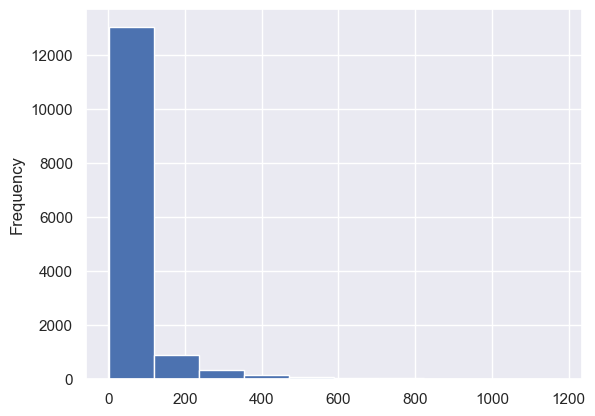

In [3]:
df['number_of_reviews'].plot.hist();

In [4]:
def outliers(x):
    q1 = np.percentile(x, 25)
    q3 = np.percentile(x, 75)
    iqr = q3 - q1
    print(f'Low-Band Outlier: {q1-1.5*iqr}')
    print(f'High-Band Outlier: {q3+1.5*iqr}')
    print('------')
    print(f'Low-Band Extreme Outlier: {q1-3*iqr}')
    print(f'High-Band Extreme Outlier: {q3+3*iqr}')

outliers(df['number_of_reviews'])

Low-Band Outlier: -59.5
High-Band Outlier: 112.5
------
Low-Band Extreme Outlier: -124.0
High-Band Extreme Outlier: 177.0


In [5]:
df.loc[df['number_of_reviews_ltm']>4, 'id'].count()

9332

In [6]:
# I keep just the listings with at least 5 reviews
# in the past 12 months

df = df[df['number_of_reviews_ltm']>4]

### Price

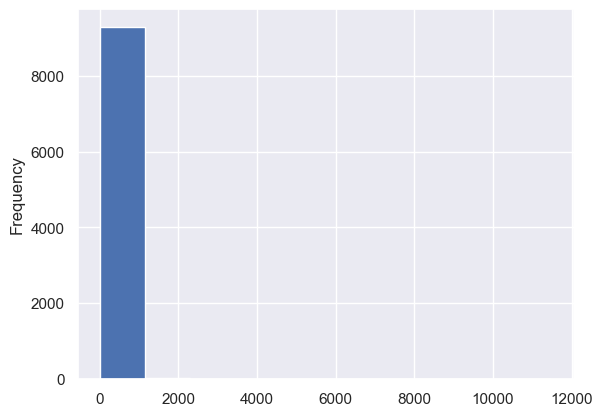

In [7]:
df['price'].plot.hist();

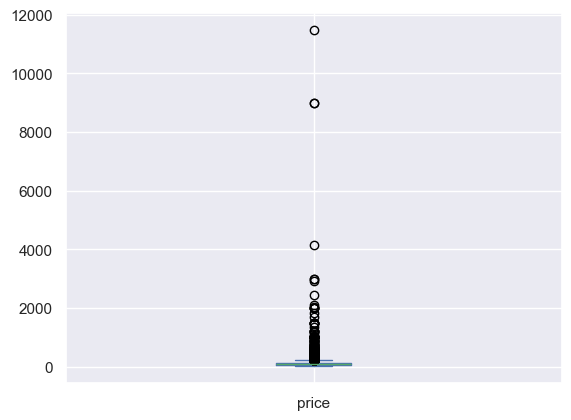

In [8]:
df['price'].plot.box();

In [9]:
outliers(df['price'])

Low-Band Outlier: -17.5
High-Band Outlier: 218.5
------
Low-Band Extreme Outlier: -106.0
High-Band Extreme Outlier: 307.0


In [10]:
# There are no listings that cost too little

df[df['price']<10]['id'].count()

0

In [11]:
# How many rows I'm deleting

df[df['price']>219]['id'].count()

712

In [12]:
# Exlude the outliers

df = df[df['price'] < 219]

### Bed

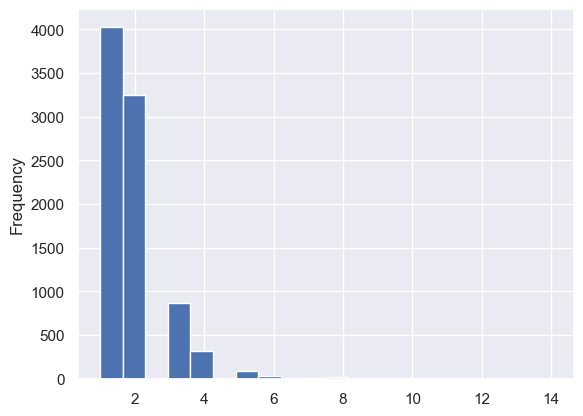

In [14]:
df['bed'].plot.hist(bins=20);

In [15]:
outliers(df['bed'])

Low-Band Outlier: -0.5
High-Band Outlier: 3.5
------
Low-Band Extreme Outlier: -2.0
High-Band Extreme Outlier: 5.0


In [16]:
df[df['bed']>4]['id'].count()

155

In [17]:
df = df[df['bed']<6]

### Bath

Low-Band Outlier: 1.0
High-Band Outlier: 1.0
------
Low-Band Extreme Outlier: 1.0
High-Band Extreme Outlier: 1.0


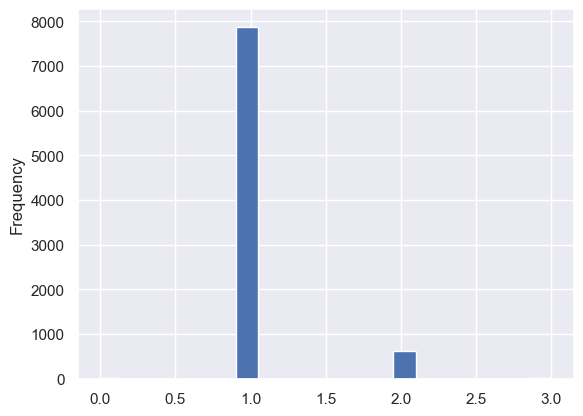

In [18]:
outliers(df['bath'])
df['bath'].plot.hist(bins=20);

In [19]:
# I've decided to keep all the bath values.
# It's not rare for a home to have 2 baths

(df['bath'] > 1).value_counts()

bath
False    7889
True      657
Name: count, dtype: int64

### Bedroom

Low-Band Outlier: 1.0
High-Band Outlier: 1.0
------
Low-Band Extreme Outlier: 1.0
High-Band Extreme Outlier: 1.0


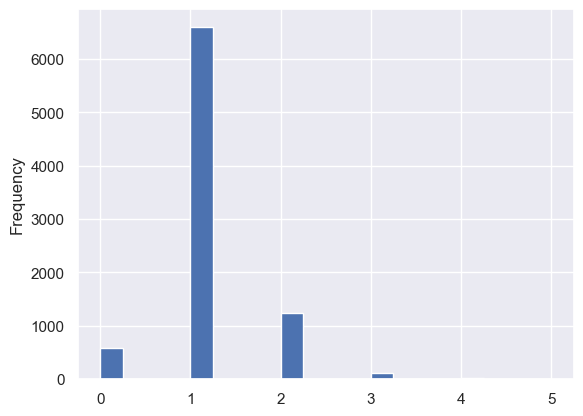

In [20]:
outliers(df['bedroom'])
df['bedroom'].plot.hist(bins=20);

In [21]:
df = df[df['minimum_nights']<6]

### Stars

In [22]:
# It's very unlikely to have 5 stars. Only the very new listings
# have 5 stars. So I delete thme

df = df[df['stars']!=5]

### Room type

In [25]:
df['room_type'].value_counts()

room_type
Entire home/apt    6537
Private room        826
Shared room          42
Hotel room            1
Name: count, dtype: int64

In [26]:
# Drop the occurrences of Hotel room and Shared room

df = df[(df['room_type'] != 'Hotel room')&(df['room_type'] != 'Shared room')]

In [27]:
# Entire home/apt = 1
# Private room = 0

df['room'] = 1
df.loc[df['room_type']=='Private room','room'] = 0

### Adding Revenue in the last 12 Months

There's no enough data to get the true revenue of the last 12 months. But we can get a proxy with this formula:

*4.2 * number_of_reviews_ltm * price*

The average number of nights per Airbnb booking in "Europe, Middle East, and Africa" in 2022 is 4.2.

[Source](https://www.statista.com/statistics/1193597/airbnb-average-nights-per-booking-by-region-worldwide/)

This is the best proxy based on the available data.

In [23]:
df['multiply'] = 4.2
df.loc[df['minimum_nights']==5, 'multiply'] = 5

In [24]:
df['revenue_ltm'] = df['multiply'] * df['number_of_reviews_ltm'] * df['price']

df.head(2)

,id,name,price,room_type,number_of_reviews,stars,bed,bedroom,bath,neighbourhood,...,longitude,minimum_nights,last_review,reviews_per_month,number_of_reviews_ltm,calculated_host_listings_count,host_id,days_online,multiply,revenue_ltm
2,304050,Rental unit in Milan · ★4.91 · 1 bedroom · 1 b...,49.0,Private room,264.0,4.91,1.0,1.0,1.0,XXII MARZO,...,9.21531,2.0,2023-11-21,1.92,33.0,2.0,1566887,4124.0,4.2,6791.4
3,46536,Rental unit in Milan · ★4.53 · 2 bedrooms · 3 ...,110.0,Entire home/apt,35.0,4.53,3.0,2.0,1.0,VIALE MONZA,...,9.22478,3.0,2023-10-30,0.24,5.0,1.0,138683,4402.0,4.2,2310.0


### Delete the 'neighbourhood' with too few occurrences

In [28]:
neigh_count = df['neighbourhood'].value_counts()
neigh_count[5:10]

neighbourhood
NAVIGLI       327
TICINESE      314
BRERA         300
ISOLA         277
XXII MARZO    196
Name: count, dtype: int64

In [29]:
# Check to see how many columns I'm deleting

print(neigh_count[neigh_count<50].count())
print(neigh_count[neigh_count>50].count())

42
37


In [30]:
neigh_count = neigh_count[neigh_count>50]

# I delete the listings that aren't in our considered neighbourhoods
df = df[df['neighbourhood'].isin(neigh_count.index.to_list())]

### Stars
Stars work better if binned because there isn't a linear relationship between them and revenue.

In [31]:
outliers(df['stars'])

Low-Band Outlier: 4.215000000000001
High-Band Outlier: 5.294999999999999
------
Low-Band Extreme Outlier: 3.8100000000000014
High-Band Extreme Outlier: 5.699999999999998


In [32]:
# See how many columns I'm deleting

(df['stars'] < 4).value_counts()

stars
False    6337
True      136
Name: count, dtype: int64

In [33]:
# It's very unlikely for a listing to have 5 stars
# that happens only to listings with few reviews.
# This may impact out analysis, so I get rid of it

df = df[(df['stars']>4) & (df['stars']!=5)]

In [34]:
# binning the stars column

df['star_group'] = pd.qcut(df['stars'], 9)

## Data Visualization

In [35]:
# The parameters has been found using GridsearchCV
from sklearn.neighbors import KernelDensity


x_d = pd.DataFrame(data={'price':np.linspace(df['price'].min(),
                                             df['price'].max(), 3000)})

# instantiate and fit the KDE model
kde = KernelDensity(bandwidth=6, kernel='gaussian')
kde.fit(df[['price']])

# get the log of the probability density
logprob = kde.score_samples(x_d)

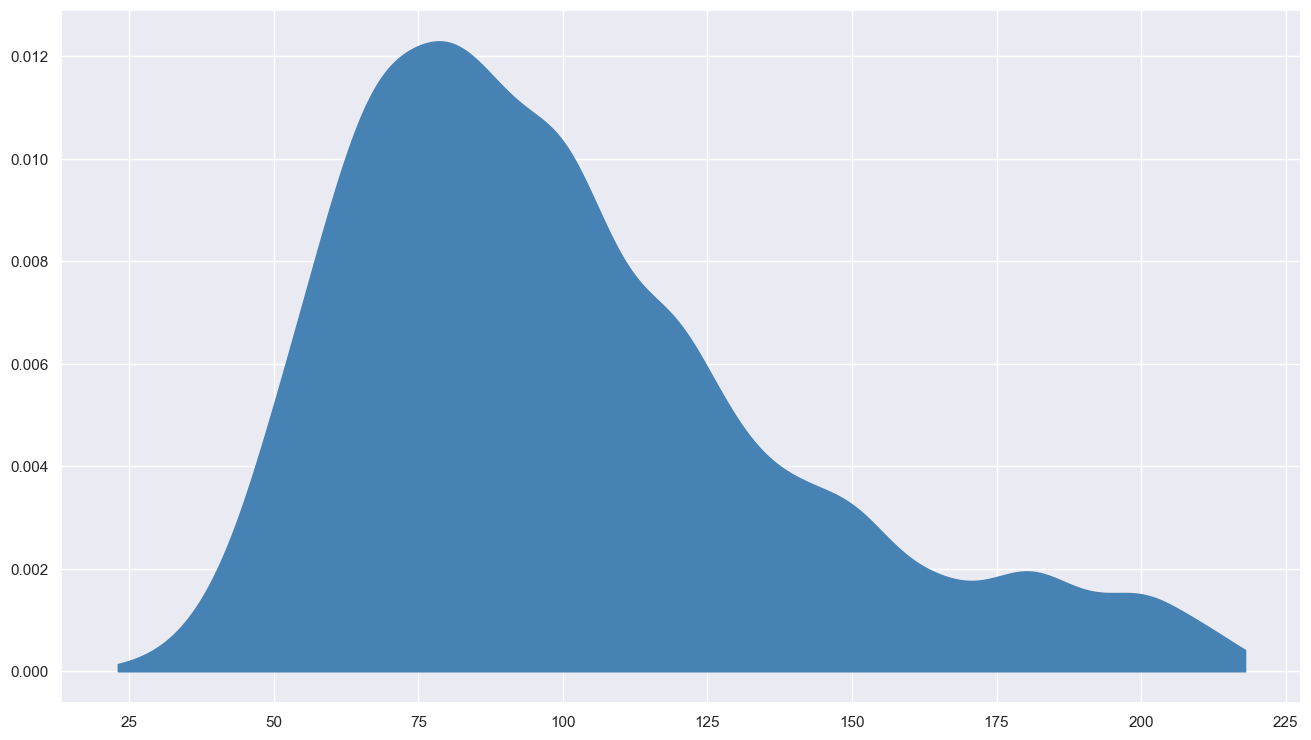

In [36]:
fig, ax = plt.subplots(figsize=(16,9))

ax.fill_between(x_d['price'],
                np.exp(logprob), alpha=1, color='steelblue');

In [70]:

x_d_reviews = pd.DataFrame(data={'revenue_ltm':np.linspace(df['revenue_ltm'].min(),
                                             30000, 1000)})

kde_r = KernelDensity(bandwidth=500.2, kernel='gaussian')
kde_r.fit(df[['revenue_ltm']])

logprob_reviews = kde_r.score_samples(x_d_reviews)

In [75]:
# Export for Tableau

revenue_dist = pd.DataFrame({'revenue_ltm':x_d_reviews['revenue_ltm'],
                             'Density':np.exp(logprob_reviews)})
revenue_dist.to_csv(r'C:\Users\matte\OneDrive\Desktop\GitHub\data\Airbnb\for_talbeau\revenue_dis.csv',
                    index=None)

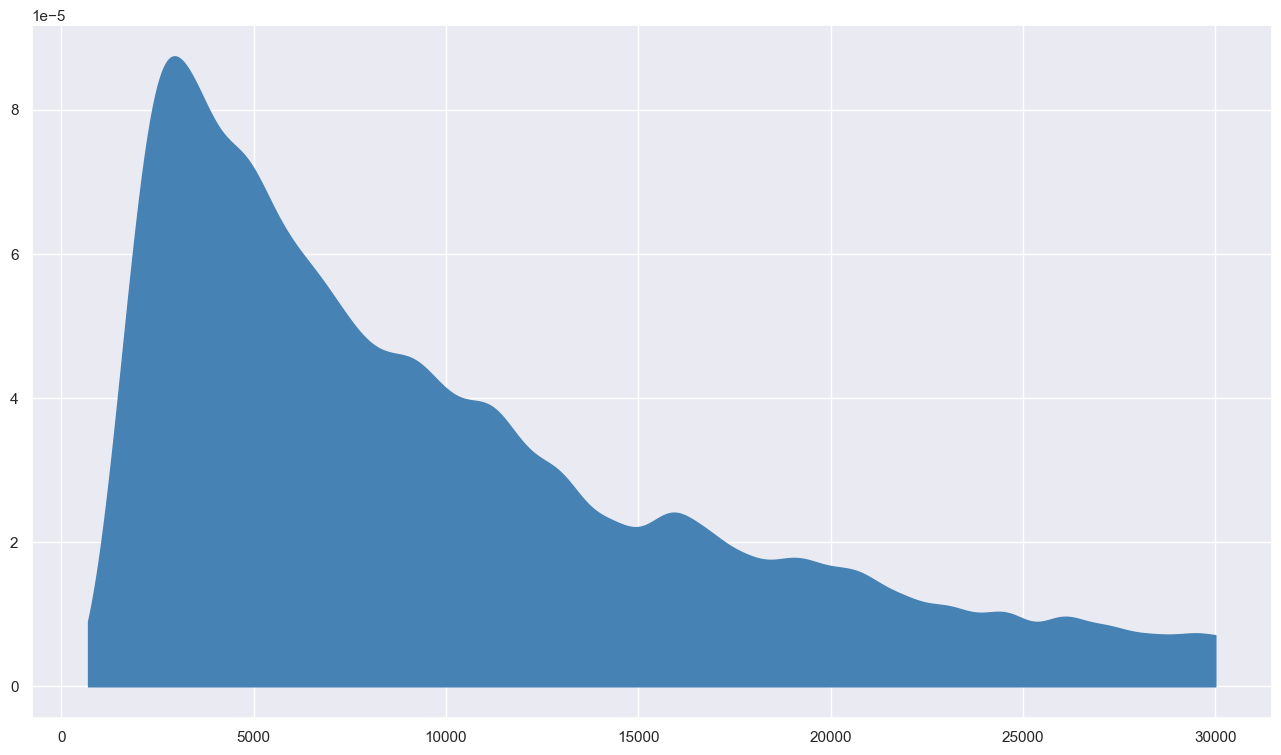

In [71]:
fig, ax = plt.subplots(figsize=(16,9))
ax.fill_between(x_d_reviews['revenue_ltm'],
                np.exp(logprob_reviews), alpha=1, color='steelblue');

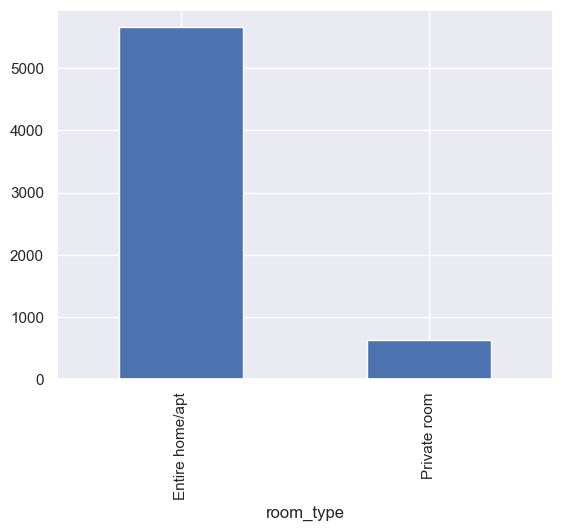

In [39]:
df.groupby('room_type')['revenue_ltm'].count().plot.bar();

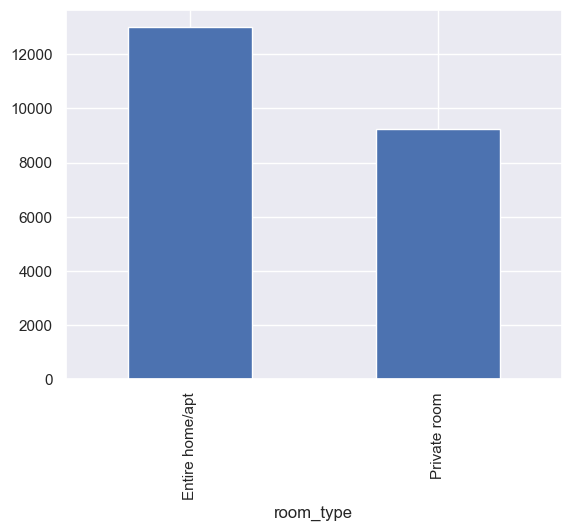

In [40]:
df.groupby('room_type')['revenue_ltm'].mean().plot.bar();

c:\Users\matte\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\matte\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\matte\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


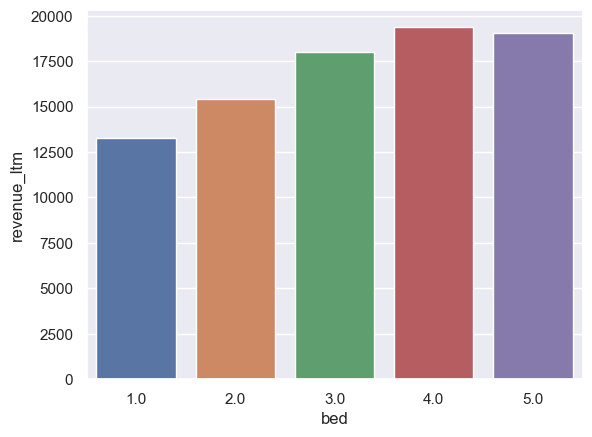

In [83]:
sns.barplot(x=df['bed'], y=df['revenue_ltm'], errorbar=None);

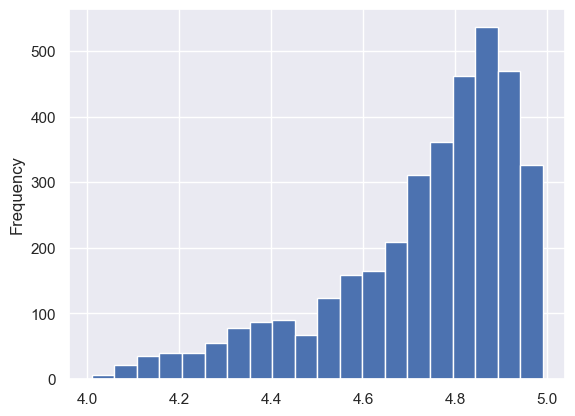

In [84]:
# The vast majority of listings have > 4 stars.

df['stars'].plot.hist(bins=20);

C:\Users\matte\AppData\Local\Temp\ipykernel_1248\1308320573.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('star_group')['revenue_ltm'].mean().plot.bar();


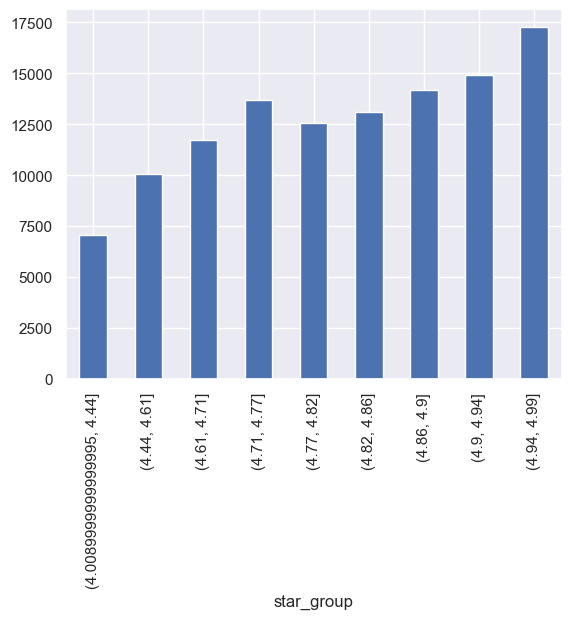

In [78]:
df.groupby('star_group')['revenue_ltm'].mean().plot.bar();

In [44]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

pd.set_option('display.float_format', '{:.6f}'.format)

## Machine Learning

### ANOVA test 'neighbourhood'

In [45]:
from scipy.stats import f_oneway

neigs = neigh_count.index.to_list()
f_oneway(*[df.loc[df['neighbourhood']==name, 'revenue_ltm'] for name in neigs])

F_onewayResult(statistic=15.021850584042033, pvalue=4.0145397601303006e-87)

#### One-hot encoding neighbourhood

In [46]:
# One hot encoding 'neighbourhood'

df = pd.concat([df,
           pd.get_dummies(df['neighbourhood'], dtype='float64')],
           axis='columns')

#### Which of the neig really influence revenue

In [47]:
# A new dataframe that has just the columns we'll use for stats model

num_col_stats = ['price','bed','bedroom','bath','minimum_nights','days_online']
cat_col_stats = ['neighbourhood','room_type','star_group']

df_stats = df[num_col_stats+cat_col_stats+['revenue_ltm']]

In [48]:
# Creating the stats models' model

formula = f'revenue_ltm ~ C(neighbourhood)'

model = ols(formula, df).fit()

print(f"Overall model F({model.df_model: .0f},{model.df_resid: .0f}) = {model.fvalue: .3f}, p = {model.f_pvalue: .4f}")

# Creates the ANOVA table
res = sm.stats.anova_lm(model, typ= 2)

model.summary()

# I'll turn the table below into a dataframe. Later, I'll keep
# only the neight really significant, p-value < 0.05

Overall model F( 36, 6251) =  15.022, p =  0.0000


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            revenue_ltm   R-squared:                       0.080
Model:                            OLS   Adj. R-squared:                  0.074
Method:                 Least Squares   F-statistic:                     15.02
Date:                Tue, 23 Jan 2024   Prob (F-statistic):           4.01e-87
Time:                        08:49:57   Log-Likelihood:                -67732.
No. Observations:                6288   AIC:                         1.355e+05
Df Residuals:                    6251   BIC:                         1.358e+05
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
===============================================================================================================
                                                  coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
Intercept                                    8132.7443   1480.647      5.493      0.000    5230.167     1.1e+04
C(neighbourhood)[T.BANDE NERE]                986.5717   1821.019      0.542      0.588   -2583.251    4556.394
C(neighbourhood)[T.BRERA]                    8429.5453   1625.605      5.185      0.000    5242.802    1.16e+04
C(neighbourhood)[T.BUENOS AIRES - VENEZIA]   5528.6417   1554.092      3.557      0.000    2482.087    8575.196
C(neighbourhood)[T.CENTRALE]                 8370.8095   1592.513      5.256      0.000    5248.936    1.15e+04
C(neighbourhood)[T.CITTA' STUDI]              178.2822   1754.410      0.102      0.919   -3260.964    3617.529
C(neighbourhood)[T.CORSICA]                   220.4466   2053.911      0.107      0.915   -3805.924    4246.817
C(neighbourhood)[T.DE ANGELI - MONTE ROSA]   2115.7072   1782.031      1.187      0.235   -1377.686    5609.101
C(neighbourhood)[T.DERGANO]                  -175.0175   2018.875     -0.087      0.931   -4132.706    3782.671
C(neighbourhood)[T.DUOMO]                    1.258e+04   1581.282      7.955      0.000    9478.986    1.57e+04
C(neighbourhood)[T.GARIBALDI REPUBBLICA]     4714.5930   1823.632      2.585      0.010    1139.648    8289.538
C(neighbourhood)[T.GHISOLFA]                 2568.7557   1945.342      1.320      0.187   -1244.783    6382.295
C(neighbourhood)[T.GIAMBELLINO]               210.4880   1808.534      0.116      0.907   -3334.860    3755.836
C(neighbourhood)[T.GRECO]                    -126.8776   2160.746     -0.059      0.953   -4362.682    4108.926
C(neighbourhood)[T.GUASTALLA]                5537.8224   1790.372      3.093      0.002    2028.078    9047.567
C(neighbourhood)[T.ISOLA]                    3176.5093   1639.957      1.937      0.053     -38.370    6391.388
C(neighbourhood)[T.LODI - CORVETTO]          1292.2801   1810.956      0.714      0.476   -2257.817    4842.377
C(neighbourhood)[T.LORETO]                   2136.6801   1612.078      1.325      0.185   -1023.546    5296.906
C(neighbourhood)[T.MACIACHINI - MAGGIOLINA]  4629.4376   1815.911      2.549      0.011    1069.627    8189.248
C(neighbourhood)[T.MAGENTA - S. VITTORE]     6316.4916   1786.144      3.536      0.000    2815.035    9817.948
C(neighbourhood)[T.NAVIGLI]                  5457.2576   1613.238      3.383      0.001    2294.758    8619.757
C(neighbourhood)[T.PADOVA]                  -1145.4808   1810.956     -0.633      0.527   -4695.578    2404.616
C(neighbourhood)[T.PAGANO]                   5275.0445   2018.875      2.613      0.009    1317.356    9232.733
C(neighbourhood)[T.PORTA ROMANA]             3237.7757   1756.092      1.844      0.065    -204.768    6680.319
C(neighbourhood)[T.S. CRISTOFORO]            3248.0176   19

In [49]:
neig_results = pd.read_html(model.summary().tables[1].as_html(),
                       header=0, index_col=0)[0]
neig_results.drop(index='Intercept', inplace=True)
neig_results.head()

C:\Users\matte\AppData\Local\Temp\ipykernel_1248\2699189960.py:1: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  neig_results = pd.read_html(model.summary().tables[1].as_html(),


,coef,std err,t,P>|t|,[0.025,0.975]
C(neighbourhood)[T.BANDE NERE],986.571700,1821.019000,0.542000,0.588000,-2583.251000,4556.394000
C(neighbourhood)[T.BRERA],8429.545300,1625.605000,5.185000,0.000000,5242.802000,11600.000000
C(neighbourhood)[T.BUENOS AIRES - VENEZIA],5528.641700,1554.092000,3.557000,0.000000,2482.087000,8575.196000
C(neighbourhood)[T.CENTRALE],8370.809500,1592.513000,5.256000,0.000000,5248.936000,11500.000000
C(neighbourhood)[T.CITTA' STUDI],178.282200,1754.410000,0.102000,0.919000,-3260.964000,3617.529000


In [50]:
# Keep only the relevant neig

good_neig = neig_results[neig_results['P>|t|']<0.05].index.to_list()
good_neig

['C(neighbourhood)[T.BRERA]',
 'C(neighbourhood)[T.BUENOS AIRES - VENEZIA]',
 'C(neighbourhood)[T.CENTRALE]',
 'C(neighbourhood)[T.DUOMO]',
 'C(neighbourhood)[T.GARIBALDI REPUBBLICA]',
 'C(neighbourhood)[T.GUASTALLA]',
 'C(neighbourhood)[T.MACIACHINI - MAGGIOLINA]',
 'C(neighbourhood)[T.MAGENTA - S. VITTORE]',
 'C(neighbourhood)[T.NAVIGLI]',
 'C(neighbourhood)[T.PAGANO]',
 'C(neighbourhood)[T.SARPI]',
 'C(neighbourhood)[T.SELINUNTE]',
 'C(neighbourhood)[T.TICINESE]',
 'C(neighbourhood)[T.VIALE MONZA]',
 'C(neighbourhood)[T.XXII MARZO]']

In [51]:
# clean good_neig

import re

patter = r'T.(.*)\]'
for n in range(len(good_neig)):
    name = re.findall(string=good_neig[n],
               pattern=patter)[0]
    good_neig[n] = name

### Train the model using only the significant neighbourhoods

In [52]:
# Create df2. A dataframe that has only neigborhoods that
# really influence revenue.

df_f = df[df['neighbourhood'].isin(good_neig)].copy()

df_f['star_group'] = pd.qcut(df_f['stars'], 5)

to_predict = 'revenue_ltm'

# I deleted bedroom because it was correlated with beds.
# That's to avoid multicollinearity

num_col_to_keep = ['bed','price','minimum_nights','days_online']

cat_col_to_keep = ['neighbourhood','star_group']

col_to_keep2 = num_col_to_keep + cat_col_to_keep + [to_predict]
df2 = df_f[col_to_keep2]
df2 = sm.add_constant(df2)

In [53]:
formula = f'{to_predict} ~ (const)'

for col in num_col_to_keep:
    formula += f' + {col}'

for col in cat_col_to_keep:
    formula += f' + C({col})'

model_f = ols(formula, df2).fit()
model_f.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            revenue_ltm   R-squared:                       0.214
Model:                            OLS   Adj. R-squared:                  0.210
Method:                 Least Squares   F-statistic:                     44.86
Date:                Tue, 23 Jan 2024   Prob (F-statistic):          7.14e-171
Time:                        08:49:58   Log-Likelihood:                -39282.
No. Observations:                3640   AIC:                         7.861e+04
Df Residuals:                    3617   BIC:                         7.875e+04
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
=========================================================================================================================
                                                            coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------
Intercept                                              2059.3131    558.679      3.686      0.000     963.957    3154.670
C(neighbourhood)[T.BUENOS AIRES - VENEZIA]            -1476.3258    856.683     -1.723      0.085   -3155.956     203.304
C(neighbourhood)[T.CENTRALE]                           1438.9903    930.890      1.546      0.122    -386.132    3264.113
C(neighbourhood)[T.DUOMO]                              4440.9548    890.753      4.986      0.000    2694.526    6187.383
C(neighbourhood)[T.GARIBALDI REPUBBLICA]              -2697.7577   1288.711     -2.093      0.036   -5224.431    -171.084
C(neighbourhood)[T.GUASTALLA]                         -1839.7498   1237.902     -1.486      0.137   -4266.804     587.305
C(neighbourhood)[T.MACIACHINI - MAGGIOLINA]           -1762.7504   1304.139     -1.352      0.177   -4319.672     794.171
C(neighbourhood)[T.MAGENTA - S. VITTORE]              -1177.0620   1233.330     -0.954      0.340   -3595.153    1241.029
C(neighbourhood)[T.NAVIGLI]                           -1814.2426    963.213     -1.884      0.060   -3702.738      74.253
C(neighbourhood)[T.PAGANO]                            -2327.4069   1567.745     -1.485      0.138   -5401.159     746.345
C(neighbourhood)[T.SARPI]                             -1992.7635    963.667     -2.068      0.039   -3882.149    -103.378
C(neighbourhood)[T.SELINUNTE]                         -1131.6727   1526.633     -0.741      0.459   -4124.819    1861.474
C(neighbourhood)[T.TICINESE]                           -341.1313    977.270     -0.349      0.727   -2257.186    1574.923
C(neighbourhood)[T.VIALE MONZA]                       -2794.1175   1344.525     -2.078      0.038   -5430.220    -158.015
C(neighbourhood)[T.XXII MARZO]                        -2623.6327   1106.284     -2.372      0.018   -4792.636    -454.630
C(star_group)[T.Interval(4.57, 4.74, closed='right')]  5128.1629    618.454      8.292      0.000    3915.609    6340.717
C(star_group)[T.Interval(4.74, 4.83, closed='right')]  6305.1737    624.887     10.090      0.000    5080.009    7530.339
C(star_group)[T.Interval(4.83, 4.9, closed='right')]   8273.0659    630.168     13.128      0.000    7037.545    9508.587
C(star_group)[T.Interval(4.9, 4.99, closed='right')]   1.098e+04    643.342     17.071      0.000    9721.394    1.22e+04
const                                                  2059.3131    558.679      3.686      0.000     963.957    3154.670
bed                                                    1192.7219    240.010      4.969      0.000     722.153    1663.291
price                                                    63.1118      5.767     10.943      0.000      51.804      74.419
minimum_nights                   

In [93]:
# Export for Tableau

df_f.iloc[:,:22].to_csv(r'C:\Users\matte\OneDrive\Desktop\GitHub\data\Airbnb\for_talbeau\listings.csv',
                        index=None)


In [54]:
# one-hot encoding star group

dummies = pd.get_dummies(df_f['star_group']).astype('float')
df_f = pd.concat([df_f, dummies], axis='columns')

### Check for multicollineariy

In [55]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

cat_col_vif = good_neig[1:] + dummies.columns.to_list()[1:]
col_vif = cat_col_vif + num_col_to_keep[:-1] # to delete 'const'

V = df_f[col_vif]
vif_data = pd.DataFrame()
vif_data["Feature"] = V.columns
vif_data["VIF"] = [variance_inflation_factor(V.values, i) for i in range(V.shape[1])]
vif_data

,Feature,VIF
0,BUENOS AIRES - VENEZIA,2.028437
1,CENTRALE,1.637414
2,DUOMO,1.870229
3,GARIBALDI REPUBBLICA,1.202925
4,GUASTALLA,1.234582
5,MACIACHINI - MAGGIOLINA,1.214511
6,MAGENTA - S. VITTORE,1.239495
7,NAVIGLI,1.558033
8,PAGANO,1.138162
9,SARPI,1.552215


c:\Users\matte\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\matte\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\matte\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\matte\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.

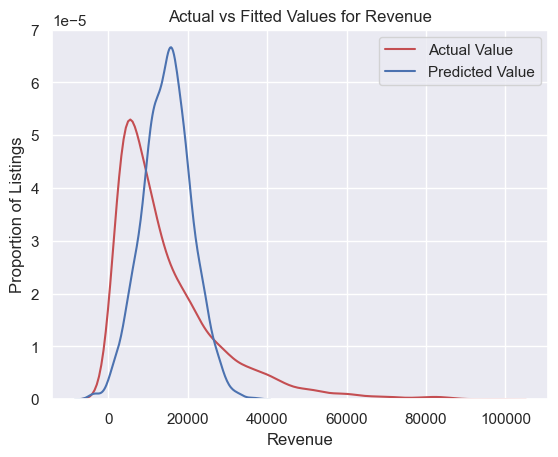

In [56]:
yhat2 = model_f.predict(df2.drop(columns='revenue_ltm'))

ax1 = sns.kdeplot(df2['revenue_ltm'], color="r", label="Actual Value")
sns.kdeplot(yhat2, color="b", label="Fitted Values" , ax=ax1)

plt.title('Actual vs Fitted Values for Revenue')
plt.xlabel('Revenue')
plt.ylabel('Proportion of Listings')
plt.legend(['Actual Value', 'Predicted Value'])
plt.show()

c:\Users\matte\anaconda3\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KernelDensity was fitted without feature names
  warnings.warn(


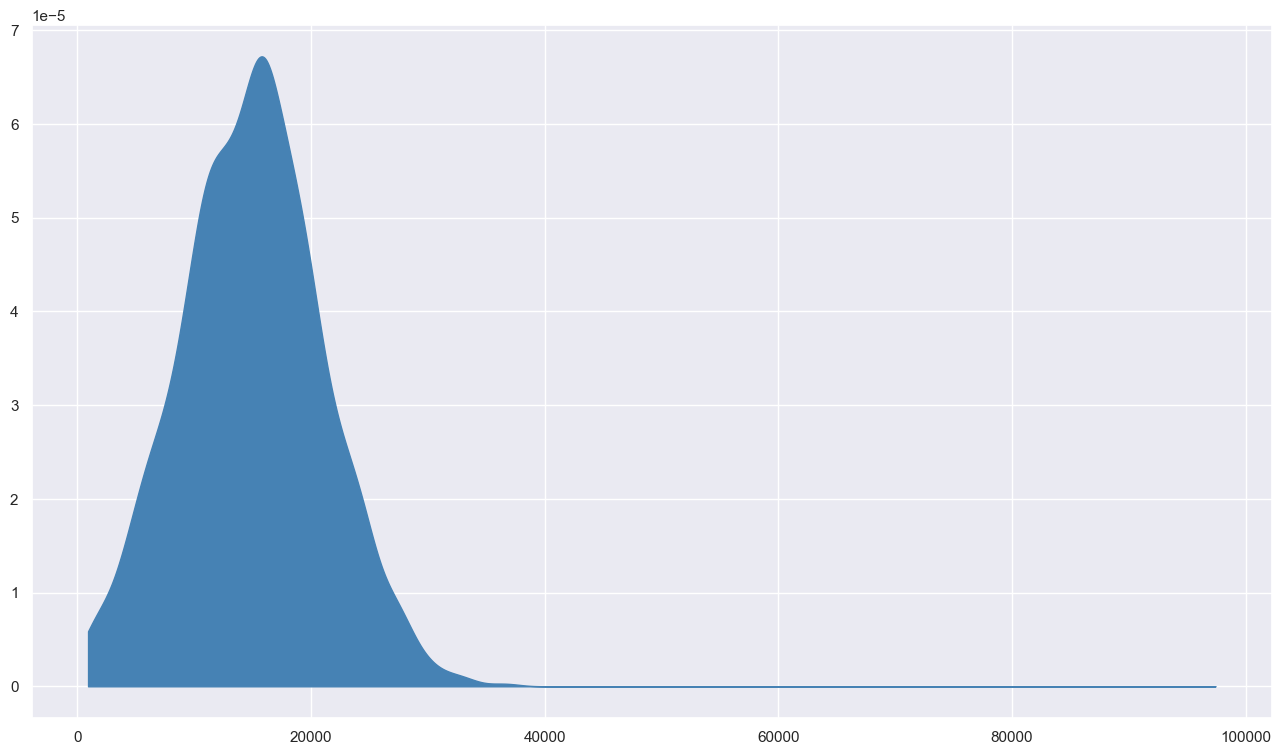

In [118]:
x_pred = pd.DataFrame(data={'revenue_ltm':np.linspace(df2['revenue_ltm'].min(),
                                             df2['revenue_ltm'].max(), 1000)})

kde_pred = KernelDensity(bandwidth=1100.2, kernel='gaussian')
kde_pred.fit(yhat2.to_frame())

logprob_pred = kde_pred.score_samples(x_pred)

fig, ax = plt.subplots(figsize=(16,9))
ax.fill_between(x_pred['revenue_ltm'],
                np.exp(logprob_pred), alpha=1, color='steelblue');

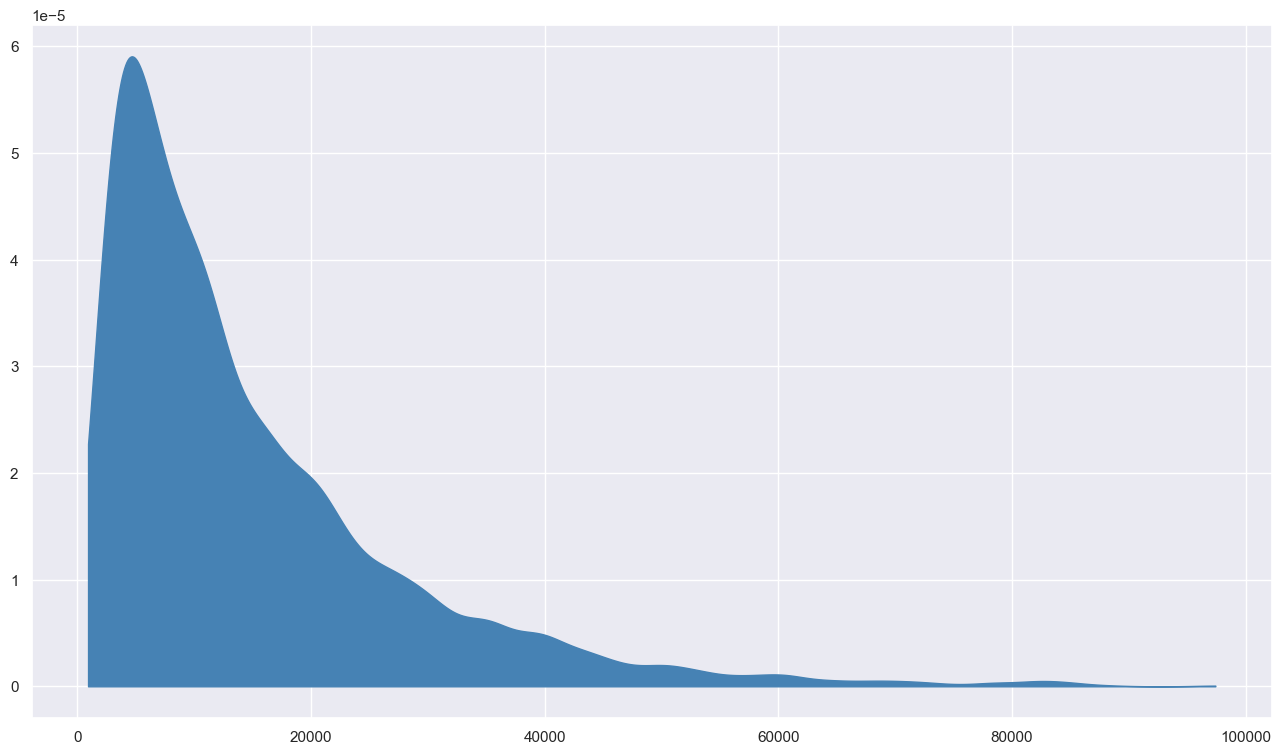

In [113]:
x_actual = pd.DataFrame(data={'revenue_ltm':np.linspace(df2['revenue_ltm'].min(),
                                             df2['revenue_ltm'].max(), 1000)})

kde_actual = KernelDensity(bandwidth=1700.2, kernel='gaussian')
kde_actual.fit(df2[['revenue_ltm']])

logprob_actual = kde_actual.score_samples(x_actual)

fig, ax = plt.subplots(figsize=(16,9))
ax.fill_between(x_actual['revenue_ltm'],
                np.exp(logprob_actual), alpha=1, color='steelblue');

In [120]:
# Export for Tableau

model_perf = pd.DataFrame({'revenue_pred':x_pred['revenue_ltm'],
                             'Density_pred':np.exp(logprob_pred),
                             'revenue_act':x_actual['revenue_ltm'],
                             'Density_act':np.exp(logprob_actual)})


model_perf.to_csv(r'C:\Users\matte\OneDrive\Desktop\GitHub\data\Airbnb\for_talbeau\model_perf.csv',
                    index=None)

### Plot findings

In [138]:
# Create a dataframe with the confidence intervals of the model

results = pd.read_html(model_f.summary().tables[1].as_html(),
                       header=0, index_col=0)[0]
results.drop(index=['Intercept','const'], inplace=True)

C:\Users\matte\AppData\Local\Temp\ipykernel_1248\3650920172.py:3: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  results = pd.read_html(model_f.summary().tables[1].as_html(),


In [139]:
# Rename the index of the dataframe

for name in results.index.to_list()[1:]:
    if name[0] == 'C':
        try:
            to_find = re.findall(string=name,
                                pattern=r'T\.(.*)\]')[0]

            found = df.filter(like=to_find[:4]).columns.to_list()[0]
            results.rename(index={name:found}, inplace=True)
        except:
            pass

results.rename(index={'C(neighbourhood)[T.BUENOS AIRES - VENEZIA]': 'BUENOS AIRES - VENEZIA'},
               inplace=True)

results.reset_index(names='name', inplace=True)

In [140]:
results

,name,coef,std err,t,P>|t|,[0.025,0.975]
0,BUENOS AIRES - VENEZIA,-1476.325800,856.683000,-1.723000,0.085000,-3155.956000,203.304000
1,CENTRALE,1438.990300,930.890000,1.546000,0.122000,-386.132000,3264.113000
2,DUOMO,4440.954800,890.753000,4.986000,0.000000,2694.526000,6187.383000
3,GARIBALDI REPUBBLICA,-2697.757700,1288.711000,-2.093000,0.036000,-5224.431000,-171.084000
4,GUASTALLA,-1839.749800,1237.902000,-1.486000,0.137000,-4266.804000,587.305000
5,MACIACHINI - MAGGIOLINA,-1762.750400,1304.139000,-1.352000,0.177000,-4319.672000,794.171000
6,MAGENTA - S. VITTORE,-1177.062000,1233.330000,-0.954000,0.340000,-3595.153000,1241.029000
7,NAVIGLI,-1814.242600,963.213000,-1.884000,0.060000,-3702.738000,74.253000
8,PAGANO,-2327.406900,1567.745000,-1.485000,0.138000,-5401.159000,746.345000
9,SARPI,-1992.763500,963.667000,-2.068000,0.039000,-3882.149000,-103.378000


In [141]:
# Export for Tableau

results.to_csv(r'C:\Users\matte\OneDrive\Desktop\GitHub\data\Airbnb\for_talbeau\results.csv')

#### Price forecast

In [60]:
# Create a dataframe with the predicted value for price

x_price = np.arange(df2.price.min(), df2.price.max()+1)
high_band_price = x_price * results.loc[results['name']=='price', '0.975]'].values
low_band_price = x_price * results.loc[results['name']=='price', '[0.025'].values

price_forecast = pd.DataFrame({'high': high_band_price, 'low': low_band_price, 'x':x_price})

In [61]:
price_forecast.head()

,high,low,x
0,1786.056000,1243.296000,24.000000
1,1860.475000,1295.100000,25.000000
2,1934.894000,1346.904000,26.000000
3,2009.313000,1398.708000,27.000000
4,2083.732000,1450.512000,28.000000


In [68]:
from scipy.stats import pearsonr

pearsonr(df['number_of_reviews_ltm'], df['price'])

PearsonRResult(statistic=-0.1118290139963778, pvalue=5.903225788413233e-19)

In [142]:
# Export for Tableau

price_forecast.to_csv(r'C:\Users\matte\OneDrive\Desktop\GitHub\data\Airbnb\for_talbeau\price_forecast.csv',
                      index=None)

c:\Users\matte\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\matte\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\matte\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\matte\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.

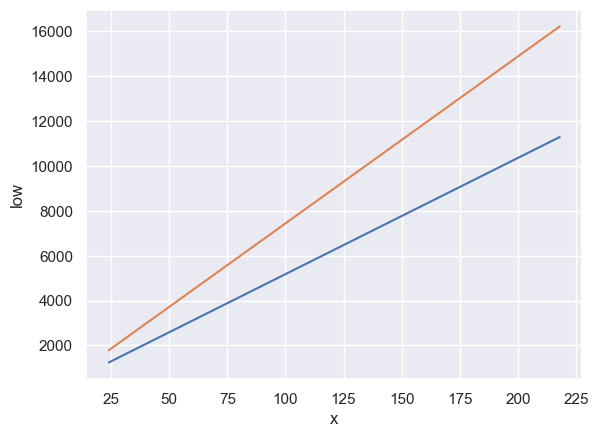

In [62]:
ax = sns.lineplot(x=price_forecast['x'], y=price_forecast['low'])
sns.lineplot(x=price_forecast['x'], y=price_forecast['high'], ax=ax);

#### Days online forecast

In [63]:
x_days = np.arange(df2.days_online.min(), 3500)
high_band_days = x_days * results.loc[results['name']=='days_online', '0.975]'].values
low_band_days = x_days * results.loc[results['name']=='days_online', '[0.025'].values

days_forecast = pd.DataFrame({'high': high_band_days,
                               'low': low_band_days, 'x':x_days})

In [143]:
# Export for Tableau

days_forecast.to_csv(r'C:\Users\matte\OneDrive\Desktop\GitHub\data\Airbnb\for_talbeau\days_forecast.csv',
                      index=None)

c:\Users\matte\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\matte\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\matte\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\matte\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.

<Axes: xlabel='x', ylabel='low'>

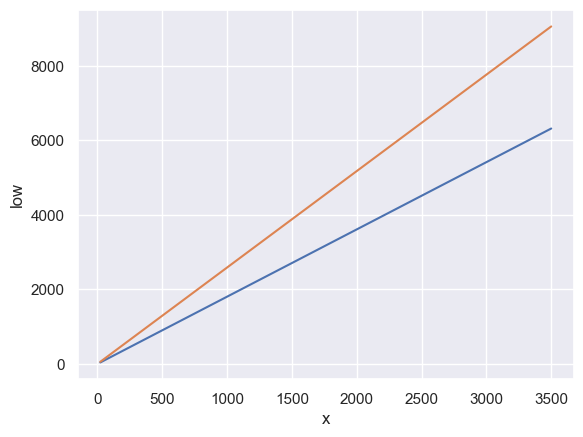

In [64]:
ax = sns.lineplot(x=days_forecast['x'], y=days_forecast['low'])
sns.lineplot(x=days_forecast['x'], y=days_forecast['high'], ax=ax)